In [16]:
import numpy as np

import seaborn as sns
import pandas as pd
import os

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult

FREE_RXNS = ["TRANS-RXN-145", "TRANS-RXN0-545", "TRANS-RXN0-474"]

sns.set(style='darkgrid', palette='viridis', context='talk')

%matplotlib inline


# Import simulation output

Before running this, run a sim in ecoli/experiments/metabolism_redux_sim.py with -n 2 to generate a simulation output. This is necessary to replicate the simulation environment. Use the default .json config.

In [2]:
experiment = 'sim_example'
entry = f'{experiment}'
folder = f'out/cofactors/{entry}/'

In [3]:
output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [4]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

In [24]:
metabolism = agent['ecoli-metabolism-redux-classic']
stoichiometry = metabolism.stoichiometry

# get concentrations
homeostatic_concs = metabolism.homeostatic_concs

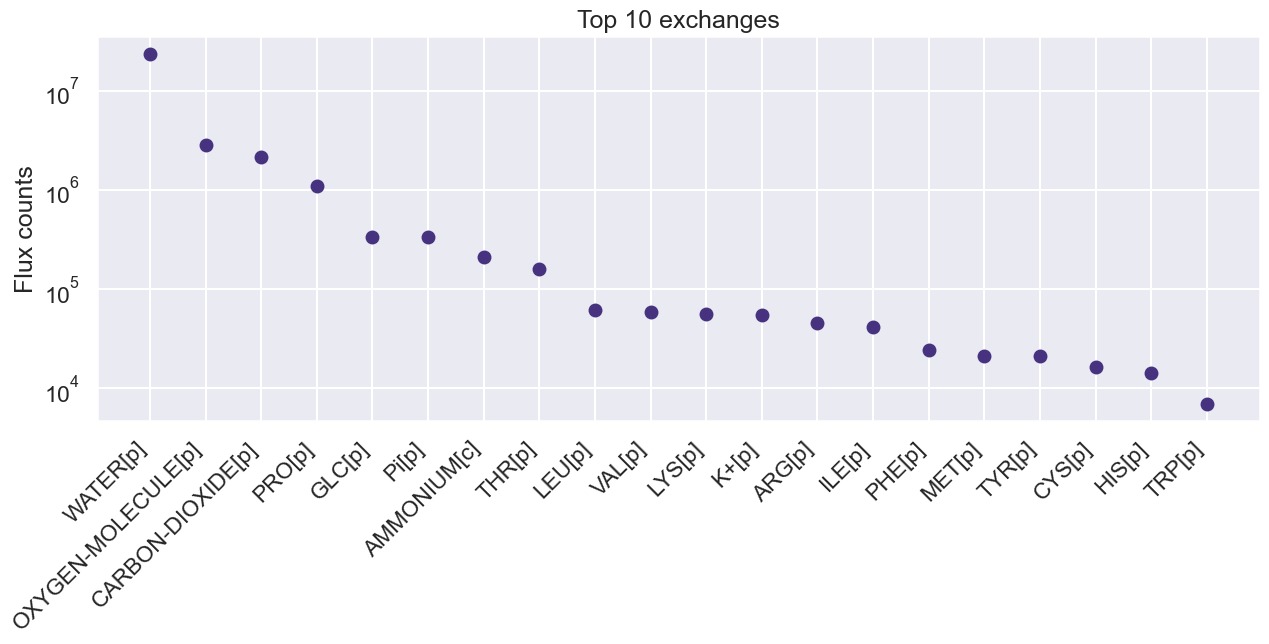

In [7]:
sim_exchanges = pd.DataFrame(fba["estimated_exchange_dmdt"])
sim_exchanges = pd.DataFrame(sim_exchanges.loc[24, :].abs().sort_values(ascending=False))
sim_exchanges.head(10)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_exchanges.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_exchanges.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 exchanges')
plt.show()

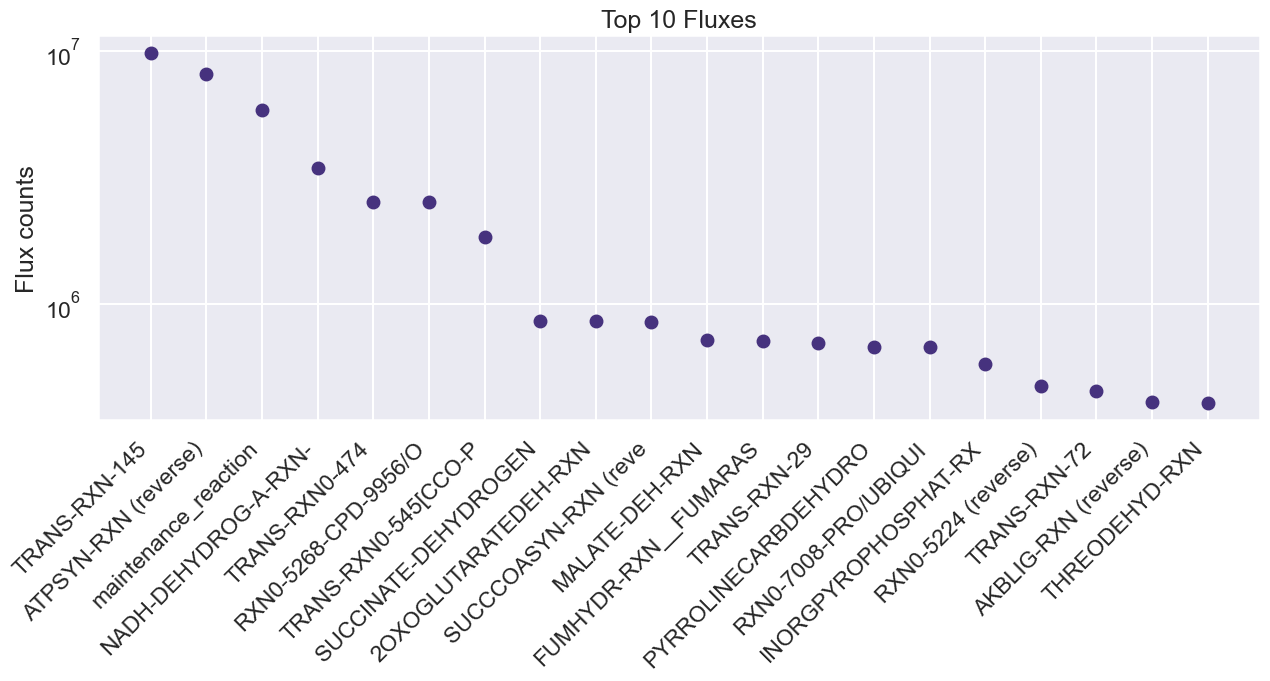

In [8]:
sim_fluxes = pd.DataFrame(fba["estimated_fluxes"], columns = metabolism.reaction_names)
sim_fluxes = pd.DataFrame(sim_fluxes.loc[4, :].abs().sort_values(ascending=False))


# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(sim_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in sim_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar


plt.ylabel('Flux counts')
# log scale
plt.yscale('log')
plt.title('Top 10 Fluxes')
plt.show()

In [9]:
sim_fluxes.head(20)

,4
TRANS-RXN-145,9788206.0
ATPSYN-RXN (reverse),8045666.0
maintenance_reaction,5815358.0
NADH-DEHYDROG-A-RXN-NADH/UBIQUINONE-8/PROTON//NAD/CPD-9956/PROTON.46.,3424411.0
TRANS-RXN0-474,2522118.0
RXN0-5268-CPD-9956/OXYGEN-MOLECULE/PROTON//UBIQUINONE-8/WATER/PROTON.59.,2521992.0
TRANS-RXN0-545[CCO-PM-BAC-NEG]-CARBON-DIOXIDE//CARBON-DIOXIDE.47. (reverse),1837770.0
SUCCINATE-DEHYDROGENASE-UBIQUINONE-RXN-SUC/UBIQUINONE-8//FUM/CPD-9956.31.,850013.0
2OXOGLUTARATEDEH-RXN,849394.0
SUCCCOASYN-RXN (reverse),842313.0


In [10]:
sim_catalysts = pd.DataFrame(fba["reaction_catalyst_counts"], columns=metabolism.reaction_names)
sim_catalysts = pd.DataFrame(sim_catalysts.loc[4, :].abs().sort_values(ascending=False))
sim_catalysts

,4
PEPTIDYLPROLYL-ISOMERASE-RXN[CCO-CYTOSOL]-CPD-8624//CPD-8625.32.,42544.0
RXN-19954,40816.0
RXN-19953-Reduced-Cys2-Peroxiredoxins/BUTYL-HYDROPEROXIDE//2Cys-Peroxiredoxins-With-HydroxyCys/BUTANOL.93.,40816.0
RXN0-5468-Reduced-CcmH-Proteins/Cys2-Peroxiredoxin-Disulfide//Oxidized-CcmH-Proteins/Reduced-Cys2-Peroxiredoxins.103.,40314.0
RXN0-5468-Reduced-CcmG-Proteins/Cys2-Peroxiredoxin-Disulfide//Oxidized-CcmG-Proteins/Reduced-Cys2-Peroxiredoxins.103.,40314.0
...,...
4.2.1.99-RXN (reverse),0.0
TRANS-RXN0-502-MANNOSE-6P/Pi//MANNOSE-6P/Pi.29.,0.0
TRANS-RXN-238-CPD-19243/ATP/WATER//CPD-19243/ADP/Pi/PROTON.45.,0.0
RXN185E-10,0.0


# Test changing nutrient composition

In [11]:
uptake = metabolism.allowed_exchange_uptake
uptake = set(uptake)

# addition = set(["CPD0-1074[c]"])
addition = set([
        # "FRU[p]",
        # "NITRATE[p]"
        # 'THIAMINE[p]',
        # 'HYDROGEN-MOLECULE[p]',
        # 'FUM[p]'
])
removals = set([
                  # "GLC[p]",
               #      # 'AMMONIUM[c]',
               #      # 'WATER[p]'
               #       # 'Pi[p]',
               #       # 'SULFATE[p]'
               # 'OXYGEN-MOLECULE[p]'
])


uptake = uptake | addition
uptake = uptake - removals
uptake

{'AMMONIUM[c]',
 'ARG[p]',
 'ASN[p]',
 'CA+2[p]',
 'CARBON-DIOXIDE[p]',
 'CL-[p]',
 'CO+2[p]',
 'CYS[p]',
 'FE+2[p]',
 'FE+3[p]',
 'GLC[p]',
 'GLN[p]',
 'GLT[p]',
 'GLY[p]',
 'HIS[p]',
 'ILE[p]',
 'K+[p]',
 'L-ALPHA-ALANINE[p]',
 'L-ASPARTATE[p]',
 'L-SELENOCYSTEINE[c]',
 'LEU[p]',
 'LYS[p]',
 'MET[p]',
 'MG+2[p]',
 'MN+2[p]',
 'NA+[p]',
 'NI+2[p]',
 'OXYGEN-MOLECULE[p]',
 'PHE[p]',
 'PRO[p]',
 'Pi[p]',
 'SER[p]',
 'SULFATE[p]',
 'THR[p]',
 'TRP[p]',
 'TYR[p]',
 'VAL[p]',
 'WATER[p]',
 'ZN+2[p]'}

# Use NetworkFlowModel class to run model

In [13]:
homeostatic = pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :]
maintenance = pd.DataFrame(fba["maintenance_target"][1:], columns=['maintenance_reaction']).iat[24, 0]
kinetic = pd.DataFrame(fba["target_kinetic_fluxes"], columns=metabolism.kinetic_constraint_reactions).loc[24, :]
maintenance

5875992

In [17]:
model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)

In [18]:
model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=metabolism.allowed_exchange_uptake)

In [20]:
homeostatic

2-3-DIHYDROXYBENZOATE[c]     90.0
2-KETOGLUTARATE[c]          229.0
2-PG[c]                      60.0
2K-4CH3-PENTANOATE[c]        90.0
4-AMINO-BUTYRATE[c]         198.0
                            ...  
NA+[p]                       65.0
OXYGEN-MOLECULE[p]           65.0
FE+3[p]                      65.0
CA+2[p]                      65.0
Pi[p]                        65.0
Name: 24, Length: 172, dtype: float64

In [28]:
objective_weights = {'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001}
solution: FlowResult = model.solve(
            homeostatic_dm_targets=np.array(list(dict(homeostatic).values())),
            homeostatic_concs=homeostatic_concs,
            maintenance_target=maintenance,
            kinetic_targets=np.array(list(dict(kinetic).values())),
            binary_kinetic_idx=[],
            objective_weights=objective_weights,
            upper_flux_bound=1000000000)

In [29]:
pd.Series(solution.exchanges).abs().sort_values(ascending=False)

5104    2.386790e+06
714     1.653601e+06
5754    5.683420e+05
5326    2.970610e+05
5395    2.921180e+05
            ...     
2028    0.000000e+00
2027    0.000000e+00
2026    0.000000e+00
2025    0.000000e+00
6075    0.000000e+00
Length: 6076, dtype: float64

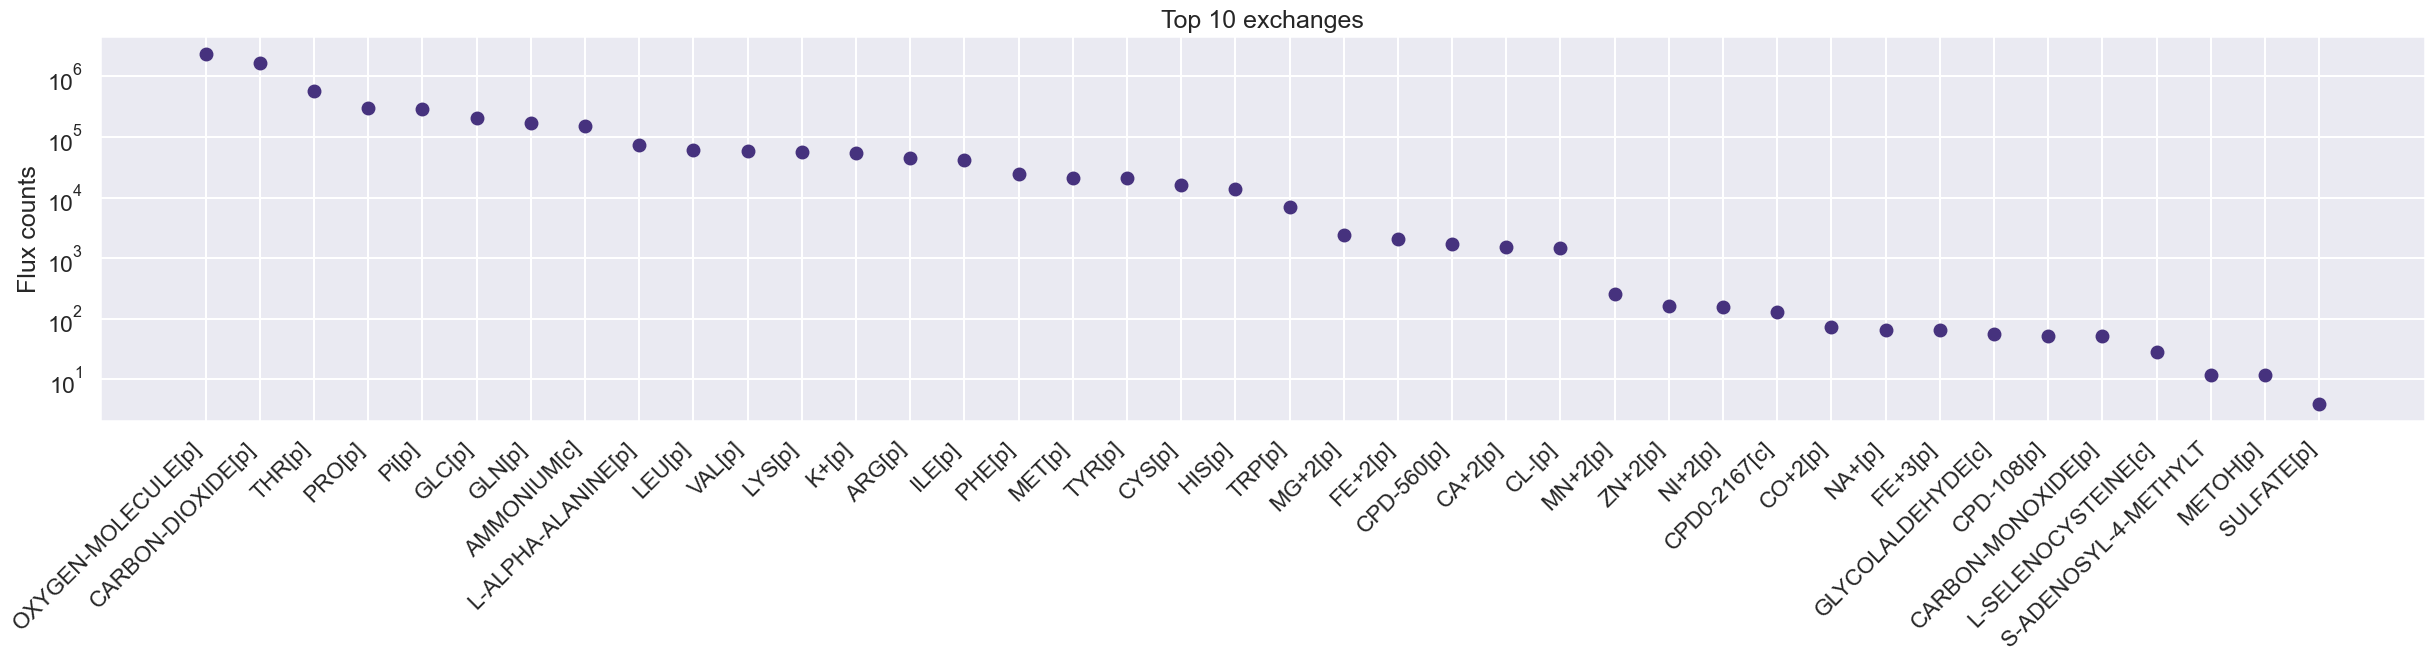

In [31]:
cur_exchanges = pd.Series(solution.exchanges, index=metabolism.metabolite_names).abs().sort_values(ascending=False)
nonzero = len(cur_exchanges[cur_exchanges > 0])

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(30, 5))
plt.plot(cur_exchanges.head(nonzero), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(nonzero)], [i[:20] for i in cur_exchanges.index[:nonzero]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 exchanges')
plt.show()

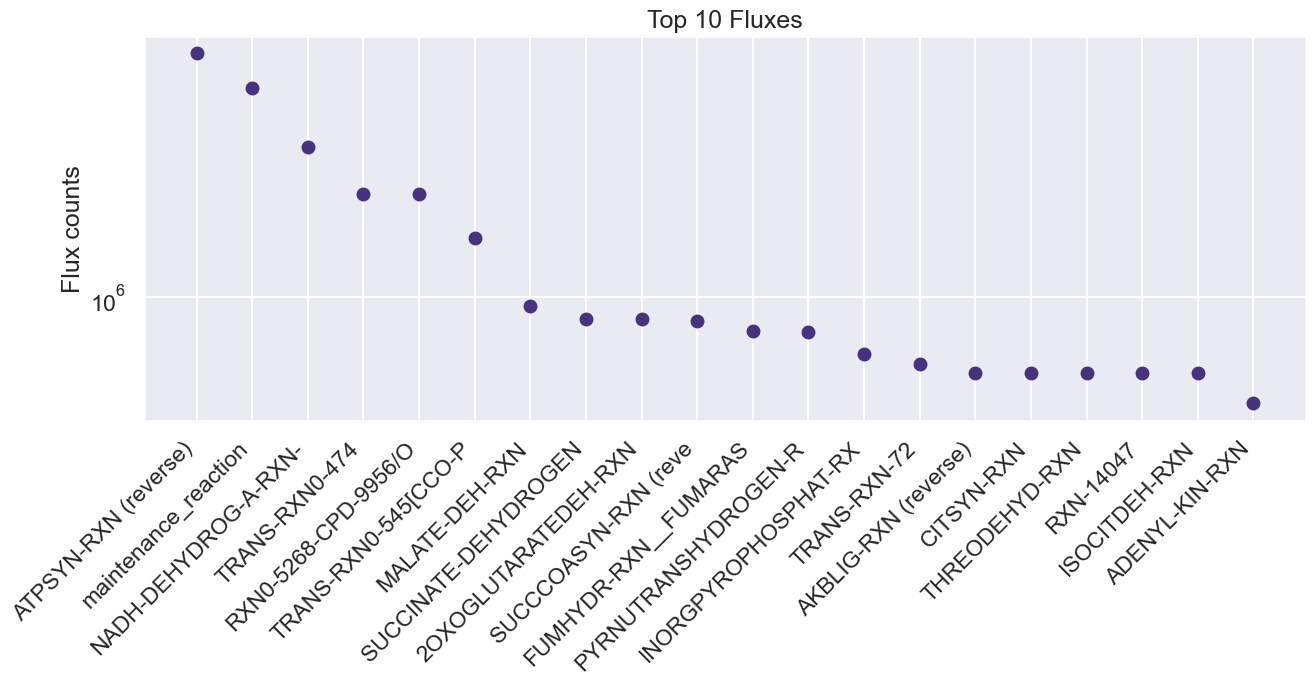

In [32]:
cur_fluxes = pd.Series(solution.velocities, index=metabolism.reaction_names).abs().sort_values(ascending=False)

# plot the top 10 fluxes from sim_fluxes as a bar plot.
plt.figure(figsize=(15, 5))
plt.plot(cur_fluxes.head(20), 'o')

# shorten all xtick names to 10 characters
plt.xticks([i for i in range(20)], [i[:20] for i in cur_fluxes.index[:20]], rotation=45, ha= 'right')
# make xticks aligned to right left of bar
plt.yscale('log')
plt.ylabel('Flux counts')
plt.title('Top 10 Fluxes')
plt.show()

## Connect to EcoCyc to go from Genes -> Reactions

In [33]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'#'})

<Response [200]>

In [34]:
condition_sets = {0: {"Environment": "Hydrogen + fumarate, -O2, -Glc",
                      "Genes": {"EG10468", "EG10469", "EG10470", "EG11799", "EG11800", "EG11801", "G7554"},
                      "Add": {"FUM[p]", 'HYDROGEN-MOLECULE[p]'},
                      "Remove": {"GLC[p]", "OXYGEN-MOLECULE[p]"},
                      },
                  
                  1: {"Environment": "Ribose C-source",
                      "Genes": {"EG10814", "EG10815", "EG10816", "EG10818"},
                      "Add": {"D-Ribopyranose[p]"},
                      "Remove": {"GLC[p]"},
                      },
                  
                  2: {"Environment": "Thiamine salvaging",
                      "Genes": {"EG11574", "G6566", "M007", "EG11573", "EG11572"},
                      "Add": {"THIAMINE[p]"},
                      "Remove": set(),
                      },
                  
                  3: {"Environment": "Nitrate as reduction target",
                      "Genes": {"EG10638", "EG10639", "EG10640", "EG10644", "EG10647", "EG10648"},
                      "Add": {"NITRATE[p]"},
                      "Remove": {"OXYGEN-MOLECULE[p]"},
                      },
                  
                  4: {"Environment": "3-Phenylpropionate as carbon and energy source",
                      "Genes": {"M010", "M011", "M012", "G6206"},
                      "Add": {"3-PHENYLPROPIONATE[p]"},
                      "Remove": {"GLC[p]"},
                      },

                  5: {"Environment": "Molybdenum cofactor synthesis",
                      "Genes": {"EG11595", "EG11666", "EG11597", "EG11598", "EG11829", "G7496", "EG10002", "EG10152",
                                "EG10153", "EG10154"},
                      "Add": {"CPD-3[p]"},
                      "Remove": set(),
                      "Demand": {"CPD-8123[c]"},
                      },

                  6: {"Environment": "pre-Quenosine synthesis",
                      "Genes": {"G6245", "G7431", "G7452"},
                      "Add": set(),
                      "Remove": set(),
                      "Demand": {"7-AMINOMETHYL-7-DEAZAGUANINE[c]"},
                      },


                  
                  # 5: {"Genes": set(["EG10286", "EG10287", "EG10288", "EG10289", 
                  #                   "EG10290", "EG10293", "EG10294", "EG10295", 
                  #                   "EG10296", "EG10298", "EG10302", "EG10303", 
                  #                   "EG10304", "EG10305", "EG10306", "G6414"]), 
                  #     "Add": set(),
                  #     "Remove": set(),
                  #     "Environment": "Proper metal (iron) uptake"}
                 }

condition_df = pd.DataFrame(condition_sets).T
condition_df["Reactions"] = [[np.nan]] * len(condition_df)
condition_df["Demand"] = condition_df["Demand"].fillna(False)
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{G7554, EG11801, EG11799, EG10470, EG11800, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{GLC[p], OXYGEN-MOLECULE[p]}",False,[nan]
1,Ribose C-source,"{EG10815, EG10816, EG10818, EG10814}",{D-Ribopyranose[p]},{GLC[p]},False,[nan]
2,Thiamine salvaging,"{EG11572, M007, EG11574, EG11573, G6566}",{THIAMINE[p]},{},False,[nan]
3,Nitrate as reduction target,"{EG10647, EG10640, EG10648, EG10639, EG10644, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},False,[nan]
4,3-Phenylpropionate as carbon and energy source,"{M010, M012, M011, G6206}",{3-PHENYLPROPIONATE[p]},{GLC[p]},False,[nan]
5,Molybdenum cofactor synthesis,"{EG10154, EG11597, EG11598, EG11595, G7496, EG...",{CPD-3[p]},{},{CPD-8123[c]},[nan]
6,pre-Quenosine synthesis,"{G7431, G6245, G7452}",{},{},{7-AMINOMETHYL-7-DEAZAGUANINE[c]},[nan]


In [35]:
for i in range(len(condition_df.index)):
    
    genes = condition_df.loc[i, "Genes"]
    rxn_set = set()

    for gene in genes:
        function = "reactions-of-gene"
        name = gene
        req_str = f"https://websvc.biocyc.org/apixml?fn={function}&id=ECOLI:{name}&detail=none&fmt=json"

        r = s.get(req_str)
        o = xmltodict.parse(r.content)['ptools-xml']['Reaction']
        if type(o) is dict:
            o = [o]
        
        for rxn in o:
            if type(rxn) is not str: # no rxns
                rxn_set.add(rxn['@frameid'])
            else:
                print(gene, rxn)
            
    condition_df.at[i, "Reactions"] = rxn_set

In [36]:
condition_df

,Environment,Genes,Add,Remove,Demand,Reactions
0,"Hydrogen + fumarate, -O2, -Glc","{G7554, EG11801, EG11799, EG10470, EG11800, EG...","{HYDROGEN-MOLECULE[p], FUM[p]}","{GLC[p], OXYGEN-MOLECULE[p]}",False,"{RXN0-5256, RXN0-7399, RXN-16420}"
1,Ribose C-source,"{EG10815, EG10816, EG10818, EG10814}",{D-Ribopyranose[p]},{GLC[p]},False,"{ABC-28-RXN, RIBOKIN-RXN}"
2,Thiamine salvaging,"{EG11572, M007, EG11574, EG11573, G6566}",{THIAMINE[p]},{},False,"{THIKIN-RXN, THIAZOLSYN3-RXN, RXN-23965, RXN0-..."
3,Nitrate as reduction target,"{EG10647, EG10640, EG10648, EG10639, EG10644, ...",{NITRATE[p]},{OXYGEN-MOLECULE[p]},False,"{RXN0-3501, RXN-15119, RXN0-7124}"
4,3-Phenylpropionate as carbon and energy source,"{M010, M012, M011, G6206}",{3-PHENYLPROPIONATE[p]},{GLC[p]},False,"{RXN-12070, MHPHYDROXY-RXN, TRANS-RXN0-457, 1...."
5,Molybdenum cofactor synthesis,"{EG10154, EG11597, EG11598, EG11595, G7496, EG...",{CPD-3[p]},{},{CPD-8123[c]},"{RXN-21563, RXN-24141, RXN-24142, ABC-19-RXN, ..."
6,pre-Quenosine synthesis,"{G7431, G6245, G7452}",{},{},{7-AMINOMETHYL-7-DEAZAGUANINE[c]},"{RXN0-4022, RXN0-5507, RXN-12093}"


## Quick and dirty loop (after init)

In [39]:
results_df = pd.DataFrame(columns=["Environment", "Reaction", "Flux"])

for i in range(len(condition_df)):
    condition_idx = i

    uptake = metabolism.allowed_exchange_uptake

    homeostatic = dict(pd.DataFrame(fba["target_homeostatic_dmdt"], columns=metabolism.homeostatic_metabolites).loc[24, :])
    new_demand = condition_df.at[condition_idx, "Demand"]
    if new_demand:
        for met in new_demand:
            homeostatic[met] = 100

    uptake = set(uptake)

    addition = condition_df.at[condition_idx, "Add"]
    removals = condition_df.at[condition_idx, "Remove"]

    uptake = uptake | addition
    uptake = uptake - removals

    model = NetworkFlowModel(
            stoich_arr=metabolism.stoichiometry,
            metabolites=metabolism.metabolite_names,
            reactions=metabolism.reaction_names,
            homeostatic_metabolites=list(dict(homeostatic).keys()),
            kinetic_reactions=list(dict(kinetic).keys()),
            free_reactions=FREE_RXNS)

    model.set_up_exchanges(exchanges=metabolism.exchange_molecules, uptakes=uptake)


    objective_weights = {'secretion': 0.01, 'efficiency': 0.0001, 'kinetics': 0.000001}
    solution: FlowResult = model.solve(
                homeostatic_targets=np.array(list(dict(homeostatic).values())),
                maintenance_target=maintenance,
                kinetic_targets=np.array(list(dict(kinetic).values())),
                binary_kinetic_idx=[],
                objective_weights=objective_weights,
                upper_flux_bound=100000000)

    # Check flux
    fluxes = pd.Series(solution.velocities, index=metabolism.reaction_names)
    # fluxes = pd.DataFrame({model.rxns[i]: [solution.velocities[model.rxns[i]]] for i in range(len(model.rxns))}).T
    fluxes.columns = ["Flux"]

    relevant_rxns = condition_df.at[condition_idx, "Reactions"]
    relevant_rxn_idx = []

    for rxn in relevant_rxns:
        relevant_rxn_idx.extend(list(np.where(fluxes.index.str.contains(rxn))[0] ))

    relevant_fluxes = fluxes.iloc[relevant_rxn_idx]
    
    relevant_nonzero_fluxes = relevant_fluxes[relevant_fluxes != 0]
    
    for j, k in enumerate(relevant_nonzero_fluxes.index):
        results_df = results_df.append(pd.DataFrame([[condition_df.at[condition_idx, "Environment"],
                          relevant_nonzero_fluxes.index[j],
                          relevant_nonzero_fluxes[k]]], columns=["Environment", "Reaction", "Flux"]))

    print(f"""finished {condition_df.at[condition_idx, "Environment"]}""")

TypeError: NetworkFlowModel.solve() got an unexpected keyword argument 'homeostatic_targets'

In [40]:
results_df["Reaction"] = results_df['Reaction'].str.slice(0,20)
results_df["log(Flux)"] = np.log10(results_df["Flux"])
results_df

,Environment,Reaction,Flux,log(Flux)


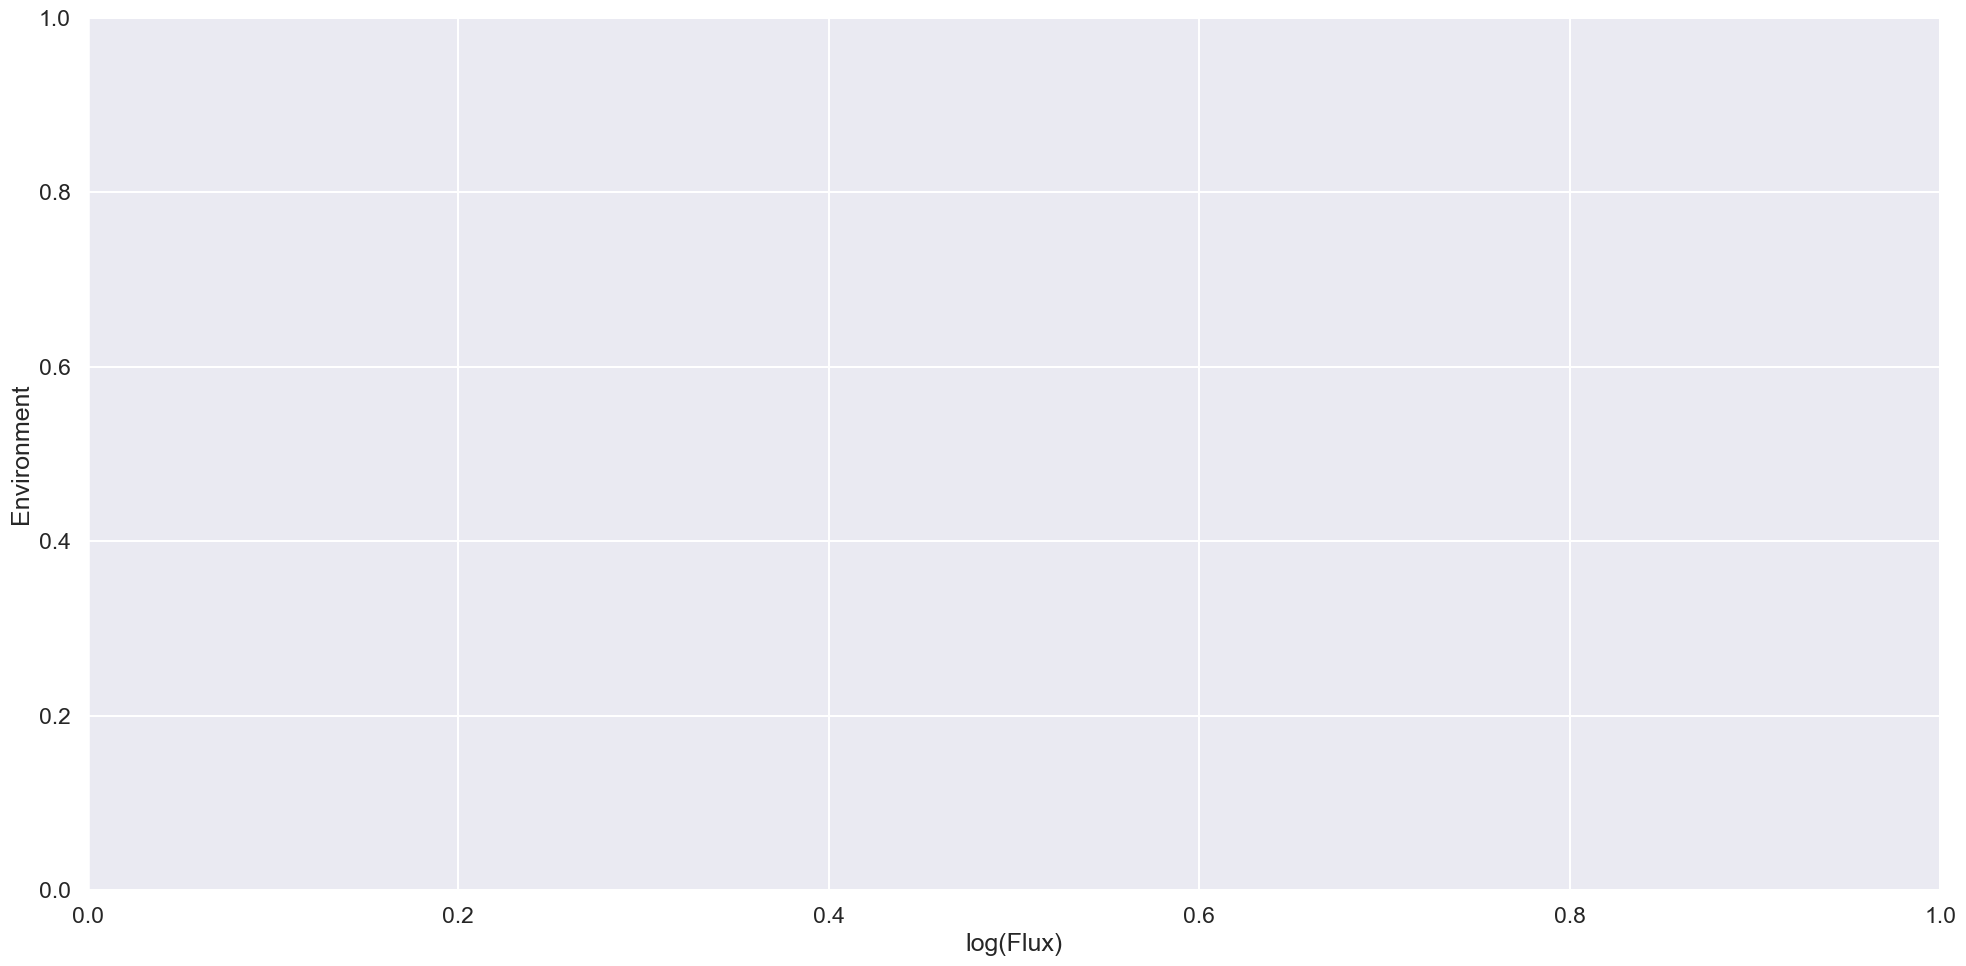

In [41]:
# for each environment, plot the fluxes of the reactions that are relevant to that environment
g = sns.catplot(y="Environment",hue="Reaction", x="log(Flux)", data=results_df, kind="bar", aspect=2, height=10, sharey=False)
g.savefig("notebooks/fbagd/figures/rxns_light_up.pdf")